<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/Hybrid%20RF-LSTM%20for%20binary%20classifications%20based%20on%20CIC-IDS2017%20DDoS%20dataset%20(12282023).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hybrid RF-LSTM for binary classifications based on CIC-IDS2017 DDoS dataset (50 epochs 12282023)**

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
#from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.utils import to_categorical

In [2]:
# Load the dataset
dataset = pd.read_csv("dataset_CIC-IDS2017.csv")

In [3]:
# Replace infinite or very large values with a finite value
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
dataset = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)  # Fill missing values with the mean of each column

In [4]:
# Perform label encoding for the target variable
label_encoder = LabelEncoder()
dataset['Class'] = label_encoder.fit_transform(dataset['Class'])
# Separate features and target variable
X = dataset.drop('Class', axis=1)
y = dataset['Class']
print(X.shape)
print(y.shape)

(225745, 78)
(225745,)


**Data Preprocessing**

In [5]:
# Data preprocessing
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

**Hybrid RF-LSTM for 10 class Ver.2.2**

In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.regularizers import l2
import numpy as np

# Train RF model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# Extract features from RF model
train_rf_features = rf_model.predict(X_train)
test_rf_features = rf_model.predict(X_test)

# Reshape RF features for LSTM input
#train_rf_features = np.reshape(train_rf_features, (train_rf_features.shape[0], 1, train_rf_features.shape[1]))
#test_rf_features = np.reshape(test_rf_features, (test_rf_features.shape[0], 1, test_rf_features.shape[1]))

# Reshape the RF features for LSTM input
train_rf_features = np.reshape(train_rf_features, (train_rf_features.shape[0], 1, 1))
test_rf_features = np.reshape(test_rf_features, (test_rf_features.shape[0], 1, 1))

In [8]:
# Train LSTM model with RF features
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, train_rf_features.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(16, kernel_regularizer=l2(0.001)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(2, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
y_train = to_categorical(y_train, num_classes=2)  # One-hot encode y_train

history = lstm_model.fit(train_rf_features, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate hybrid model on test set
test_lstm_features = lstm_model.predict(test_rf_features)
test_rf_lstm_predictions = np.argmax(test_lstm_features, axis=1)

Epoch 1/50
2561/2561 [==============================] - 30s 9ms/step - loss: 0.0801 - accuracy: 0.9859 - val_loss: 0.0156 - val_accuracy: 1.0000
Epoch 2/50
2561/2561 [==============================] - 22s 8ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 3/50
2561/2561 [==============================] - 22s 9ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 4/50
2561/2561 [==============================] - 22s 9ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 5/50
2561/2561 [==============================] - 21s 8ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 6/50
2561/2561 [==============================] - 22s 8ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 7/50
2561/2561 [==============================] - 22s 8ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0024 - val_ac

Confusion Matrix:
[[25489     0]
 [    7 25715]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25489
           1       1.00      1.00      1.00     25722

    accuracy                           1.00     51211
   macro avg       1.00      1.00      1.00     51211
weighted avg       1.00      1.00      1.00     51211



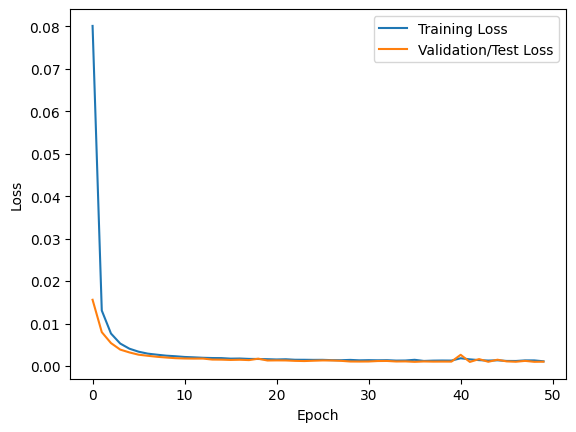

In [9]:
import collections as c

# Calculate the confusion matrix and classification report
# Ensure that y_test and test_rf_lstm_predictions are 2D arrays
confusion = confusion_matrix(y_test, test_rf_lstm_predictions)
classification_report_result = classification_report(y_test, test_rf_lstm_predictions)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification_report_result)

# Plot the training and validation loss over each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Compute TP, TN, FP, FN for each class
cm = confusion_matrix(y_test, test_rf_lstm_predictions)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Compute False Positive Rate (FPR) and True Positive Rate (TPR) for each class
FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

# Print FPR and TPR for each class
for i in range(2):
    print(f"Class {i} - FPR: {FPR[i]}, TPR: {TPR[i]}")

Class 0 - FPR: 0.00027214058004820774, TPR: 1.0
Class 1 - FPR: 0.0, TPR: 0.9997278594199518


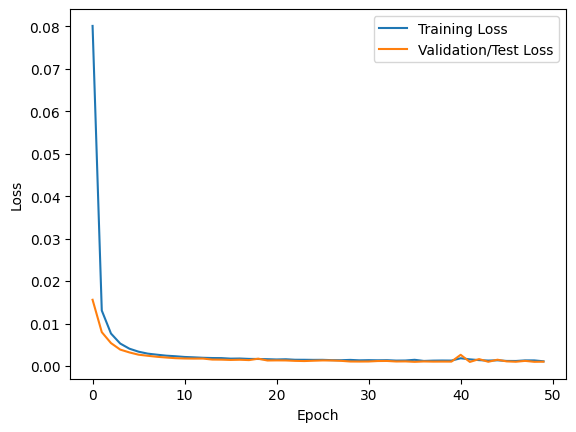

In [11]:
# Plot training/validation loss over each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, test_rf_lstm_predictions)
recall = recall_score(y_test, test_rf_lstm_predictions, average='weighted')
precision = precision_score(y_test, test_rf_lstm_predictions, average='weighted')
f1score = f1_score(y_test, test_rf_lstm_predictions, average='weighted')
confusion_mat = confusion_matrix(y_test, test_rf_lstm_predictions)
classification_rep = classification_report(y_test, test_rf_lstm_predictions)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1score)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9998633106168596
Recall: 0.9998633106168596
Precision: 0.9998633481453223
F1-Score: 0.9998633106993158
Confusion Matrix:
 [[25489     0]
 [    7 25715]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     25489
           1       1.00      1.00      1.00     25722

    accuracy                           1.00     51211
   macro avg       1.00      1.00      1.00     51211
weighted avg       1.00      1.00      1.00     51211



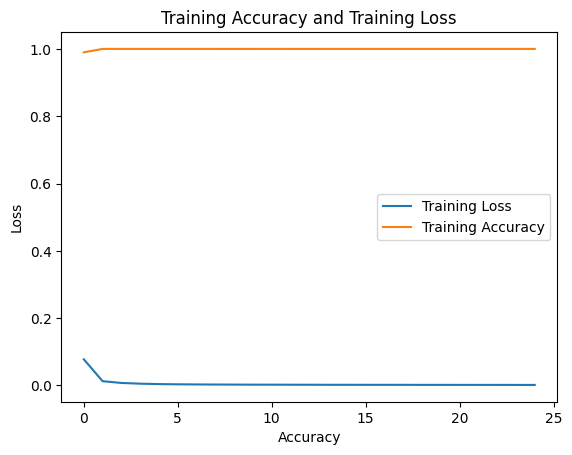

In [24]:
# Plot training loss and validation/test loss over each epoch of training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy and Training Loss')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()

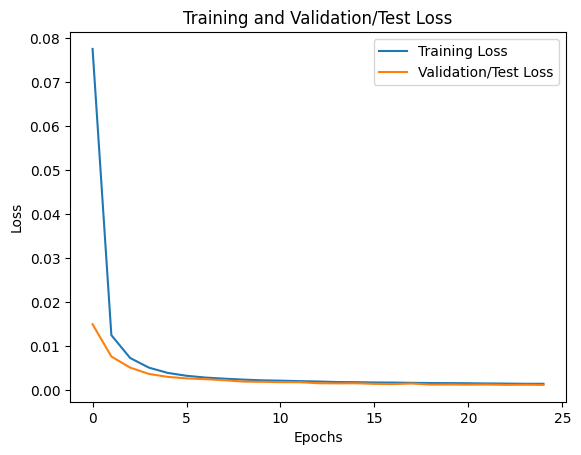

In [25]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Training and Validation/Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  plt.figure(figsize=(6,5.5))
  ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='bone')
  sns.set(font_scale=1)

  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['BENIGN','DDoS'])
  ax.yaxis.set_ticklabels(['BENIGN','DDoS'])

  #plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  #plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees

  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


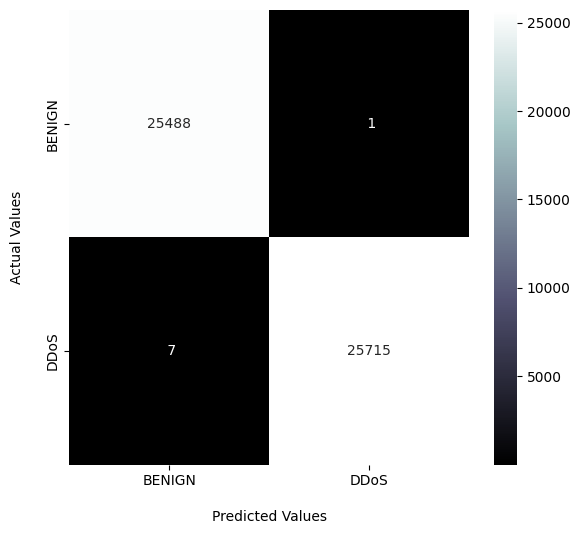

In [30]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
conf_mat(y_test, test_rf_lstm_predictions)

In [34]:
report = classification_report(y_test, test_rf_lstm_predictions, output_dict=True)
detection_rates = {}
for cls in range(2):
    detection_rates[label_encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']
print("Detection rates of Hybrid RF-LSTM Model:", detection_rates)

Detection rates of Hybrid RF-LSTM Model: {0.0: 0.9999607673898544, 1.0: 0.9997278594199518}


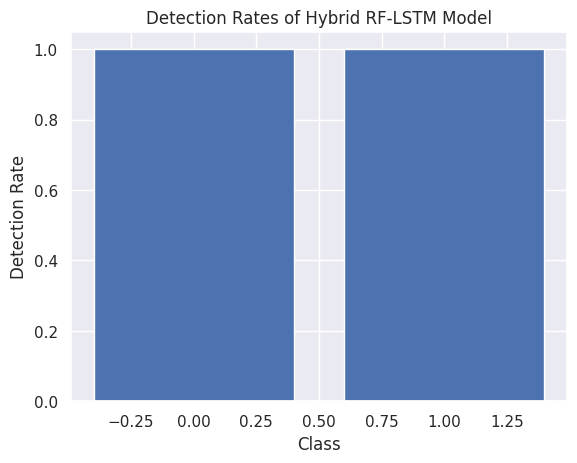

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

report = classification_report(y_test, test_rf_lstm_predictions, output_dict=True)
detection_rates = {}
for cls in range(2):
    detection_rates[label_encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']

# Plot detection rates
labels = detection_rates.keys()
rates = detection_rates.values()

plt.bar(labels, rates)
plt.xlabel('Class')
plt.ylabel('Detection Rate')
plt.title('Detection Rates of Hybrid RF-LSTM Model')
plt.show()

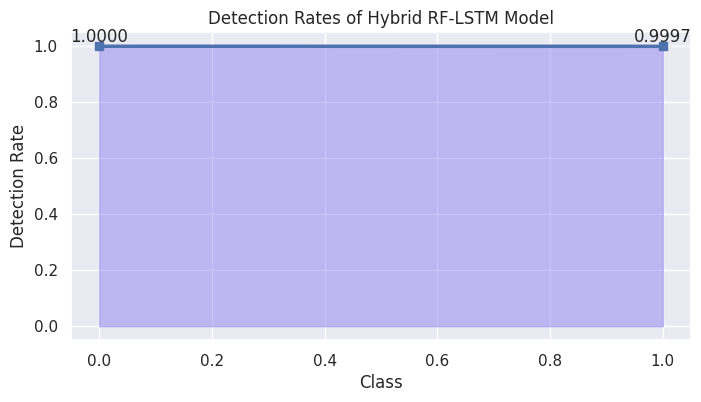

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

report = classification_report(y_test, test_rf_lstm_predictions, output_dict=True)
detection_rates = {}
for cls in range(2):
    detection_rates[label_encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']

# Extract the class labels and detection rates
labels = list(detection_rates.keys())
rates = list(detection_rates.values())

# Plot the line graph with filled area and labels
plt.figure(figsize=(8, 4))
plt.plot(labels, rates, marker='s', linestyle='-', linewidth=2.5)
plt.fill_between(labels, rates, color='mediumslateblue', alpha=0.4)

# Add labels to each data point
for i in range(len(labels)):
    plt.text(labels[i], rates[i], "{:.4f}".format(rates[i]), ha='center', va='bottom')

plt.xlabel('Class')
plt.ylabel('Detection Rate')
plt.title('Detection Rates of Hybrid RF-LSTM Model')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#from keras.utils import np_utils
from tensorflow.python.keras.utils import np_utils

# Convert y_test and test_rf_lstm_predictions to one-hot encoded format
y_test_onehot = np_utils.to_categorical(y_test, axis=1)
test_rf_lstm_predictions_onehot = np_utils.to_categorical(test_rf_lstm_predictions, num_classes=2) # Convert to one-hot encoded format with 10 classes

# Compute the AUC and ROC curves for each class
n_classes = y_test_onehot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], test_rf_lstm_predictions_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), test_rf_lstm_predictions_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure()
colors = ['blue', 'red']  # Adjust the colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.6f})'.format(i, roc_auc[i]))

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2, linestyle='--', label='Micro-average (AUC = {0:0.6f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print confusion matrix and classification report
##print(confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))
##print(classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))

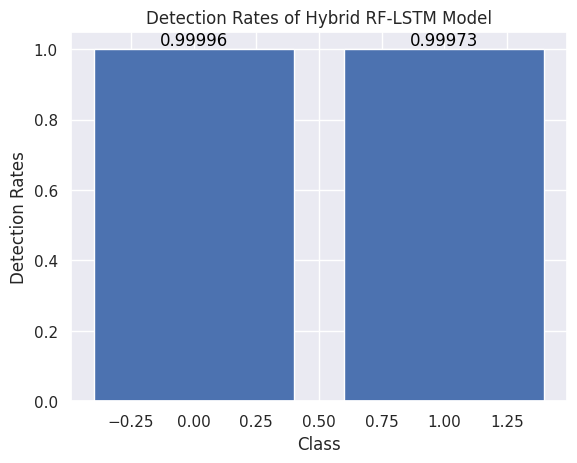

In [38]:
import matplotlib.pyplot as plt

# Extract the labels and rates from the detection rates dictionary
labels = list(detection_rates.keys())
rates = list(detection_rates.values())

# Plot the bar chart
plt.bar(labels, rates)

# Add labels and units to each bar
for i in range(len(labels)):
    plt.text(labels[i], rates[i], "{:.5f}".format(rates[i]), ha='center', va='bottom', color='black')

# Add axis labels and title
plt.xlabel('Class')
plt.ylabel('Detection Rates')
plt.title('Detection Rates of Hybrid RF-LSTM Model')

# Display the plot
plt.show()